In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, classification_report, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

# *Load the Data*

In [63]:
df = pd.read_csv('cleaned_data.csv')

# Splitting Of Data

In [64]:
X = df.drop(['cardio'], axis=1)
y = df.cardio.copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Preprocessing

In [65]:
num_cols = ['height', 'weight', 'ap_hi', 'ap_lo', 'pulse_pressure', 'age_years', 'bmi', 'lifestyle_score']
ordinal_cat_cols = ['cholesterol', 'gluc']
nominal_cat_cols = ['bp_category', 'bmi_category']
passthrough_cols = ['gender','smoke','alco','active','is_obese']

# Numerical preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Ordinal categorical preprocessing (cholesterol and gluc where 1 < 2 < 3)
ordinal_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[[1, 2, 3]] * len(ordinal_cat_cols)))
])

# Nominal categorical preprocessing (bp_category, bmi_category)
nominal_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
    ('num_prep', numerical_transformer, num_cols),
    ('ord_prep', ordinal_categorical_transformer, ordinal_cat_cols),
    ('nom_prep', nominal_categorical_transformer, nominal_cat_cols)
], remainder='passthrough')



In [66]:
# Feature selector
selector = SelectKBest(score_func=f_classif,k = 15)

full_preprocess_selector = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector)
])

X_train_processed_selected = full_preprocess_selector.fit_transform(X_train, y_train)

X_test_processed_selected = full_preprocess_selector.transform(X_test)

all_feature_names = preprocessor.named_transformers_['nom_prep'].named_steps['onehot'].get_feature_names_out(nominal_cat_cols)
other_features = num_cols + ordinal_cat_cols + passthrough_cols
combined_feature_names = np.concatenate([num_cols, ordinal_cat_cols, all_feature_names, passthrough_cols])
selected_indices = selector.get_support(indices=True)
selected_features = combined_feature_names[selected_indices]
print("Selected Features:", selected_features.tolist())


Selected Features: ['weight', 'ap_hi', 'ap_lo', 'pulse_pressure', 'age_years', 'bmi', 'cholesterol', 'gluc', 'bp_category_Elevated', 'bp_category_Hypertension Stage 1', 'bp_category_Hypertension Stage 2', 'bp_category_Normal', 'bmi_category_Normal', 'bmi_category_Obese', 'is_obese']


In [82]:
pipelines = {
    'lr': Pipeline([('clf', LogisticRegression(max_iter=1000, solver='liblinear'))]),
    'rf': Pipeline([('clf', RandomForestClassifier(random_state=42))]),
    'svm': Pipeline([('clf', LinearSVC(max_iter=10000, dual=False))]),
    'xgb': Pipeline([('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]),
    'knn': Pipeline([('clf', KNeighborsClassifier())]),
    'dt': Pipeline([('clf', DecisionTreeClassifier(random_state=42))])  
}


# Hyperparameter Tuning

In [68]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

best_models = {}
accuracy_results = {}
# 1. Logistic Regression (keep GridSearch, small grid)
lr_params = {'C': [0.1, 1]}
lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3)
lr.fit(X_train_processed_selected, y_train)
accuracy_results['Logistic Regression'] = accuracy_score(y_test, lr.predict(X_test_processed_selected))
best_models['Logistic Regression'] = lr.best_estimator_

In [69]:
# 2. Decision Tree
dt_params = {'max_depth': [5, 10], 'criterion': ['gini']}
dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=3)
dt.fit(X_train_processed_selected, y_train)
accuracy_results['Decision Tree'] = accuracy_score(y_test, dt.predict(X_test_processed_selected))
best_models['Decision Tree'] = dt.best_estimator_

In [70]:
# 3. Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, None]
}
rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=3, random_state=42)
rf.fit(X_train_processed_selected, y_train)
accuracy_results['Random Forest'] = accuracy_score(y_test, rf.predict(X_test_processed_selected))
best_models['Random Forest'] = rf.best_estimator_

In [ ]:
# 4. SVM 
svm_params = {
    'C': [0.1, 1],  
    'kernel': ['linear'],
}
svm = GridSearchCV(SVC(), svm_params, cv=3, n_jobs=-1)  
svm.fit(X_train_processed_selected, y_train)
accuracy_results['SVM'] = accuracy_score(y_test, svm.predict(X_test_processed_selected))
best_models['SVM'] = svm.best_estimator_

In [72]:
# 5. KNN
knn_params = {'n_neighbors': [5, 7]}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3)
knn.fit(X_train_processed_selected, y_train)
accuracy_results['KNN'] = accuracy_score(y_test, knn.predict(X_test_processed_selected))
best_models['KNN'] = knn.best_estimator_

In [73]:
# 6. XGBoost
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1]
}
xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                         xgb_params, cv=3, n_iter=3, random_state=42)
xgb.fit(X_train_processed_selected, y_train)
accuracy_results['XGBoost'] = accuracy_score(y_test, xgb.predict(X_test_processed_selected))
best_models['XGBoost'] = xgb.best_estimator_

In [74]:
print("Accuracy Scores (after preprocessing + feature selection):")
for model_name, acc in accuracy_results.items():
    print(f"{model_name}: {acc:.4f}")

Accuracy Scores (after preprocessing + feature selection):
Logistic Regression: 0.7272
Decision Tree: 0.7318
Random Forest: 0.7288
SVM: 0.7168
KNN: 0.7035
XGBoost: 0.7370


In [ ]:
param_grids = {
    'lr': {'clf__C': [0.01, 0.1, 1]},
    'rf': {'clf__n_estimators': [100], 'clf__max_depth': [5, 10]},
    'svm': {'clf__C': [0.1, 1], 'clf__penalty': ['l1', 'l2'], 'clf__loss': ['squared_hinge']},
    'xgb': {'clf__n_estimators': [100], 'clf__learning_rate': [0.01, 0.1], 'clf__max_depth': [3]},
    'knn': {'clf__n_neighbors': [3, 5], 'clf__weights': ['uniform', 'distance']},
    'dt': {'clf__max_depth': [3, 5, 10],'clf__min_samples_split': [2, 5],'clf__criterion': ['gini', 'entropy']}
}

# Classification Metrics

In [76]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in best_models.items():
    y_train_pred = model.predict(X_train_processed_selected)
    y_test_pred = model.predict(X_test_processed_selected)
    result = {
        'Model': name,
        'Best_Params': model.get_params() if hasattr(model, 'get_params') else 'N/A',
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1_Score': f1_score(y_test, y_test_pred),
        'Best_Model': model
    }
    results.append(result)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Test_Accuracy', ascending=False).reset_index(drop=True)
results_df.head(6)

,Model,Best_Params,Train_Accuracy,Test_Accuracy,Precision,Recall,F1_Score,Best_Model
0,XGBoost,"{'objective': 'binary:logistic', 'base_score':...",0.734532,0.736969,0.762342,0.678794,0.718146,"XGBClassifier(base_score=None, booster=None, c..."
1,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.729547,0.731838,0.782929,0.632017,0.699425,DecisionTreeClassifier(max_depth=5)
2,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.725313,0.728832,0.765995,0.648946,0.702629,"(DecisionTreeClassifier(max_depth=5, max_featu..."
3,Logistic Regression,"{'C': 0.1, 'class_weight': None, 'dual': False...",0.723737,0.727219,0.765089,0.645679,0.700330,"LogisticRegression(C=0.1, max_iter=1000)"
4,SVM,"{'C': 0.1, 'break_ties': False, 'cache_size': ...",0.716315,0.716810,0.802784,0.565192,0.663355,"SVC(C=0.1, kernel='linear')"
5,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.765963,0.703541,0.706036,0.684437,0.695069,KNeighborsClassifier(n_neighbors=7)


In [77]:
for model_name, pipeline in pipelines.items():
    print(f"\n{'='*40}\nTraining Model: {model_name}\n{'='*40}")
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grids[model_name],
        n_iter=20,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    search.fit(X_train_processed_selected, y_train)
    best_model = search.best_estimator_
    y_train_pred = best_model.predict(X_train_processed_selected)
    y_test_pred = best_model.predict(X_test_processed_selected)
    results.append({
        'Model': model_name,
        'Best_Params': search.best_params_,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='macro'),
        'Recall': recall_score(y_test, y_test_pred, average='macro'),
        'F1_Score': f1_score(y_test, y_test_pred, average='macro'),
        'Classification_Report': classification_report(y_test, y_test_pred, output_dict=True),
        'Best_Model': best_model
    })
    print(f"Best Parameters: {search.best_params_}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))


Training Model: lr
Best Parameters: {'clf__C': 0.01}
Train Accuracy: 0.7238
Test Accuracy: 0.7268

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6907
           1       0.76      0.65      0.70      6734

    accuracy                           0.73     13641
   macro avg       0.73      0.73      0.72     13641
weighted avg       0.73      0.73      0.72     13641


Training Model: rf
Best Parameters: {'clf__n_estimators': 100, 'clf__max_depth': 10}
Train Accuracy: 0.7448
Test Accuracy: 0.7344

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      6907
           1       0.77      0.66      0.71      6734

    accuracy                           0.73     13641
   macro avg       0.74      0.73      0.73     13641
weighted avg       0.74      0.73      0.73     13641


Training Model: svm
Best Parameters: {'clf__penalty': 'l1', 'clf__l

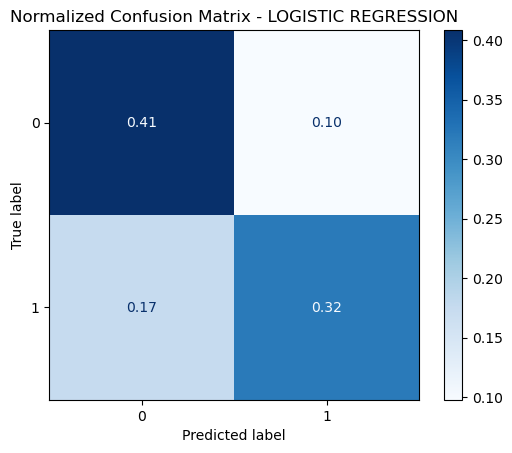

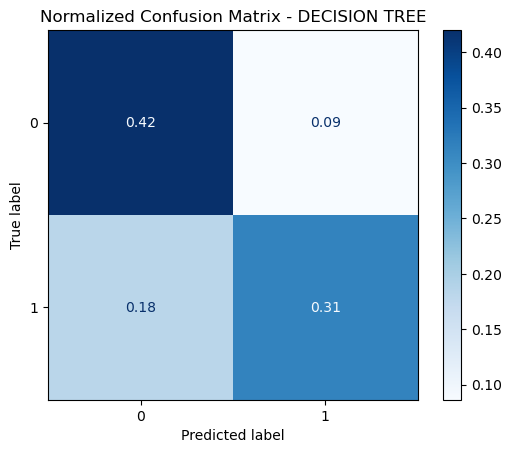

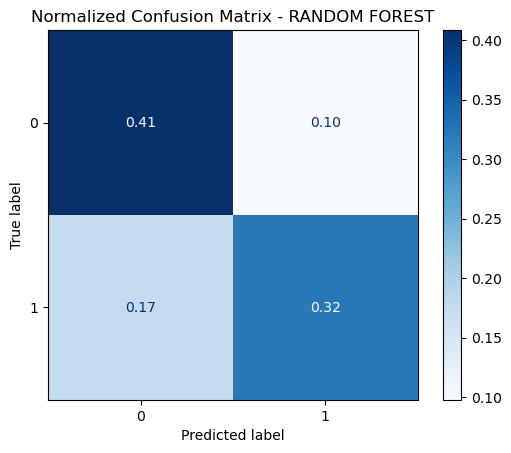

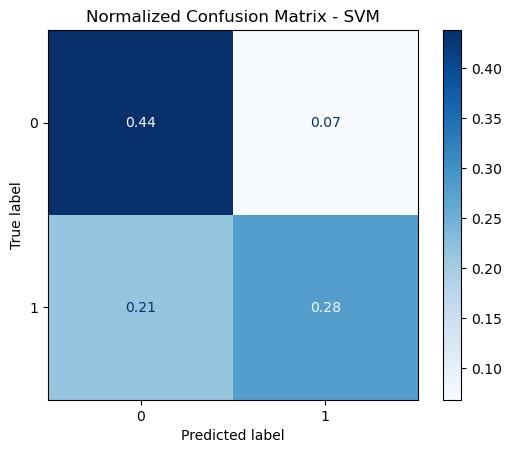

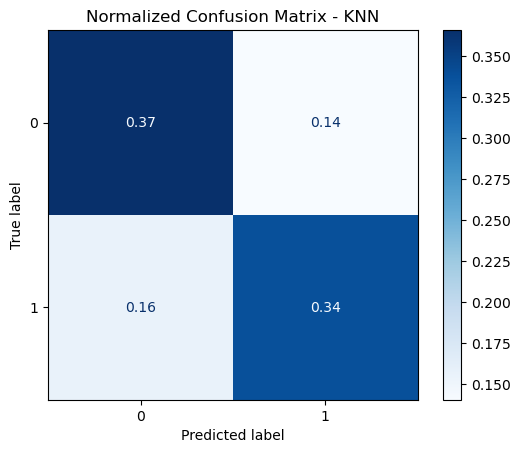

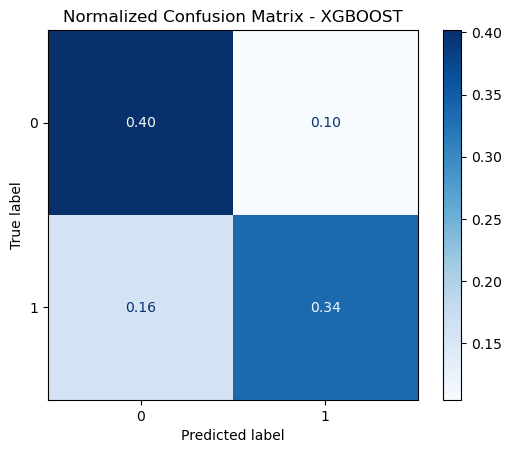

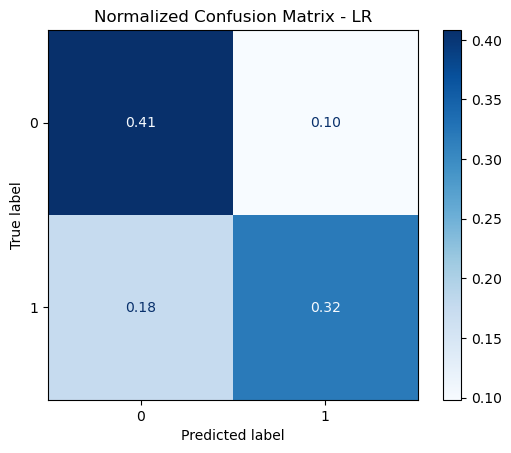

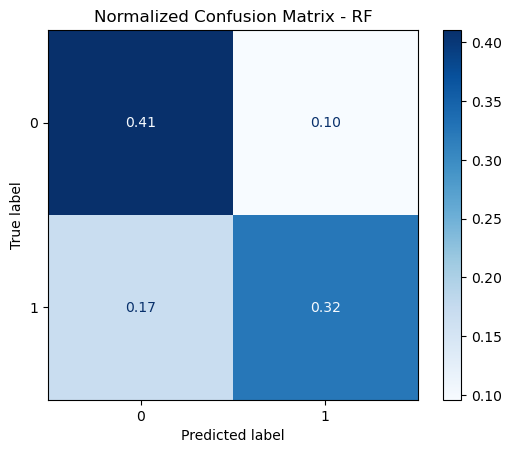

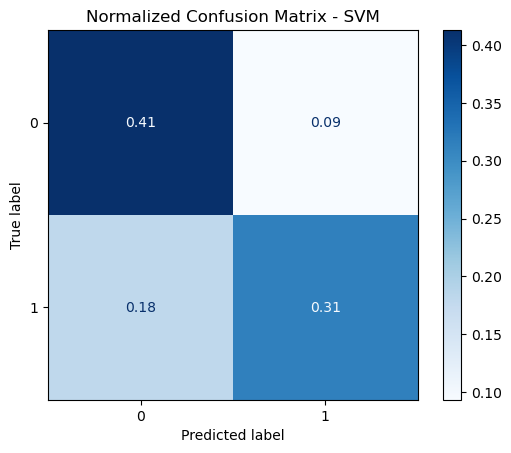

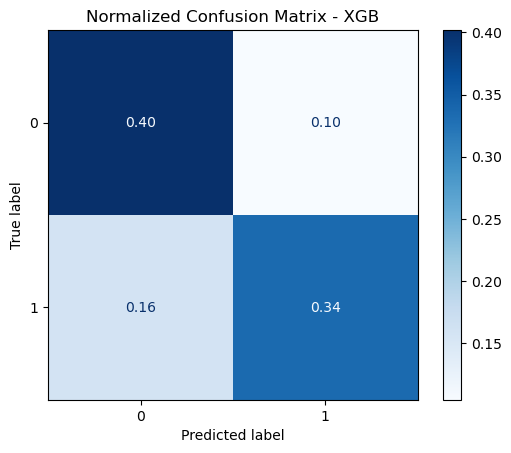

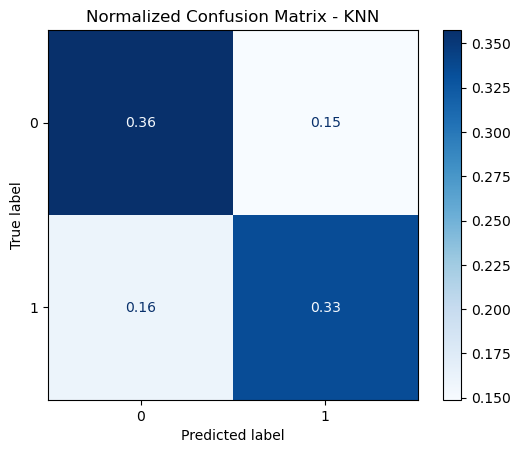

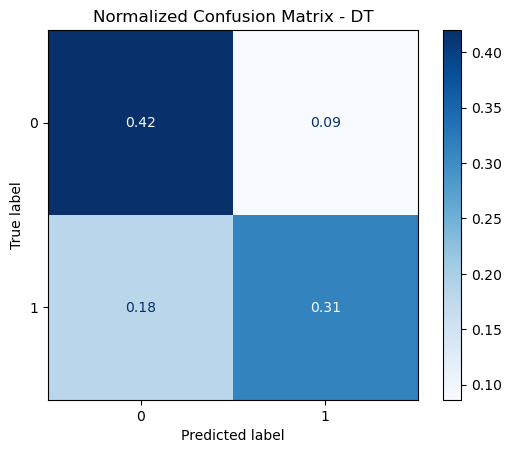

In [78]:
for model_info in results:
    model = model_info['Best_Model']
    name = model_info['Model']
    # Use the preprocessed data for the confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test_processed_selected, y_test, normalize='all',cmap='Blues',values_format='.2f')
    plt.title(f'Normalized Confusion Matrix - {name.upper()}')
    plt.show()

# Save the Best Model

In [79]:
for result in results:
    if result['Model'] == 'xgb':
        xgb_model = result['Best_Model']
        break
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
with open('feature_selector.pkl', 'wb') as f:
    pickle.dump(selector, f)
with open('xgboost_best_model.json', 'wb') as f:
    pickle.dump(xgb_model, f)
print("Preprocessor, feature selector, and best model saved successfully.")

Preprocessor, feature selector, and best model saved successfully.


# *Test the Model is saved correctly*

In [80]:
with open('preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
with open('feature_selector.pkl', 'rb') as f:
    selector = pickle.load(f)
with open('xgboost_best_model.json', 'rb') as f:
    loaded_xgb_model = pickle.load(f)
X_test_processed = preprocessor.transform(X_test)
X_test_processed_selected = selector.transform(X_test_processed)
y_pred = loaded_xgb_model.predict(X_test_processed_selected)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.7369694303936661
